<a href="https://colab.research.google.com/github/hyunee9/AI/blob/main/%EC%9D%B8%EA%B3%B5%EC%8B%A0%EA%B2%BD%EB%A7%9D_MLP_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MLP를 MNIST dataset을 이용해서 훈련시킨다.
MNIST dataset : 미국 표준 연구소에서 만든 데이터셋.
손으로 쓴 숫자 이미지를 저장하고 있음.
28x28, 흑백 이미지.

(이미지, 레이블)의 쌍. pytorch에서 제공함.
이미지를 읽어서 이미지가 어떤 숫자인지 인식하는 MLP를 설계하고 훈련.

# 1. import library

In [ ]:
# 1. numpy
import numpy as np
# 2. pytorch
import torch
import torch.nn as nn # neural network
import torch.optim as optim #gradient descent method를 구현
import torchvision.datasets as dset #pytorch에서 제공하는 dataset -> MNIST
import torchvision.transforms as transforms #data를 훈련하기 위해서 관리하는 libraray
from torch.utils.data import DataLoader # 데이터를 읽어들이는 library
from torch.autograd import Variable # numpy의 배열을 pytorch의 변수로 변환 -> 자동 미분하려고


# 3. matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# 2. MLP구현 = 모델 설계

In [ ]:
# n_input : 28 x 28 = 784
# 1st hidden : 256
# 2nd hidden : 128
# n_output : 10
model = nn.Sequential(
    nn.Linear (784, 256), #784를 받아서 256을 뽑음. input -> 1st hidden
    nn.Sigmoid(), #activation function
    nn.Linear (256, 128), #1st hidden -> 2nd hidden
    nn.Linear (128, 10), #2nd -> output
)


# 3. 데이터 로딩 (MNIST)

In [ ]:
# MNISt dataset = train set + test set
mnist_train = dset.MNIST("", train = True, transform = transforms. ToTensor(),
                         target_transform = None, download = True)

mnist_test = dset.MNIST("", train = False, transform = transforms.ToTensor(),
                       target_transform = None, download = True)
#transform : 들어오는 데이터를 어떤 형태로 바꿀 것인지


## 3.1 data 확인

mnist_train의 길이: 60000
mnist_test의 길이:  10000
image의 크기:  torch.Size([1, 28, 28])
label:  3
torch.FloatTensor


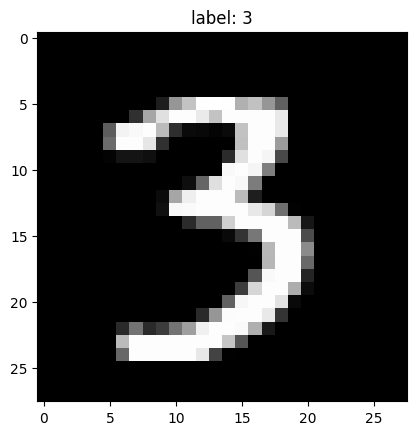

In [ ]:
#download받은 data의 크기는?
print("mnist_train의 길이:", len(mnist_train))
print("mnist_test의 길이: ", len(mnist_test))

#하나의 데이터는 어떤 모양?
image, label = mnist_train.__getitem__ (10000)
print("image의 크기: ", image.size()) #이미지 한장 한장은 tensor가 됨. (위에서 ToTensor)
print("label: ", label)

#이미지를 그려보기 -> 그리기는 mayplotlib을 사용할 건데
# matplotlib의 입력은 numpy array만 가능함. 그래서 이미지를 넘파이에서 쓸 수 있는 형태로 바꿔줌
img = image.numpy () #pytorch의 Tensor를 numpy의 ndarray로 변환
print(image.type())
plt.title("label: %d" %label)
plt.imshow(img[0], cmap = 'gray')
plt.show()

# 4. 초기 설정

## 4.1 hyperparameter 설정

In [ ]:
# batch_size : 한 번에 훈련할 데이터의 양
batch_size = 1024
#learning rate : 학습률 - 작을수록 안정적인지만 느리다
learning_rate = 0.001
#epoch : 몇 번이나 훈련 시킬지
num_epoch = 500

## 4.2 dataloader 설정
어떻게 데이터를 mnist 데이터의 train, test를 잘라서 사용할건지

In [ ]:
train_loader = torch.utils.data.DataLoader (mnist_train,
                                            batch_size = batch_size,
                                            shuffle = True, # 섞어서 넣음
                                            num_workers = 2,
  #실제 데이터를 넣고 있는 동안에 넣지 않은 데이터에 대해서 미리 자르고 있을지.
  #그렇다면 몇 개씩 자를지
                                            drop_last = True
  #남는 데이터는 버려주세요
                                            )
test_loader = torch.utils.data.DataLoader(mnist_test,
                                          batch_size = batch_size,
                                          shuffle = False, #테스트니까 안해도 됨.
                                          num_workers = 2,
                                          drop_last = True)

## 4.3 loss함수와 optimizer를 설정

In [ ]:
#loss function을 criterion 이라고 많이 쓴다.
#회귀 : mean square, 분류 : cross entropy를 씀

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

# 5. 훈련

## 5.1 Accuracy 측정 함수 정의

In [ ]:
# accuracy = 맞는 답의 수(correct) / 전체 답의 수(total)
def ComputeAccuracy (dloader, imodel):
  #전체 답의 수, 맞는 답의 수
  total = 0
  correct = 0

  #dloader를 이용해서 data를 불러오는 과정을 수행
  for j, [imgs, labels] in enumerate(dloader):  #batch_size개 만큼의 [img, label]을 읽어 옴
      img = imgs
      # print(len(img))
      label = Variable(labels) #pytorch variable로 바꿔줌
      img = Variable(img, requires_grad = False) #훈련 과정이기 때문에 미분하지 않음.

      #img data는 1024 x 1 x 28 x 28
      #model의 입력은 1024 x 28 x 28 (둘의 차원이 다름)
      #문제를 해결하기 위해서는 주워진 데이터가 차원이 맞도록 조정해줘야함
      #reshape이용
      #model의 입력은 1024 x 784 (28 x 28)였음. 한 번 더 변환 필요

      #print(img.shape)
      img = img.reshape((img.shape[0], img.shape[2], img.shape[3]))
      #print(img.shape)
      img = img.reshape((img.shape[0], img.shape[1] * img.shape[2]))
      #print(img.shape)
      #출력 생성
      output = imodel (img) #output : 10개의 확률. i번째 확률은 label이 i일 확률 -> argmax 해서 가장 큰 인덱스를 찾는다.
      _, output_index = torch.max(output, 1)
      total += label.size(0) #전체 데이터의 갯수는 레이블 사이즈 만큼 증가
      correct += (output_index == label).sum().float() #읽어들인 것들 중에 가장 큰 값의 인덱스가 현재 레이블과 같은 것들을 다 더해야 함

  print("Accuracy : {}".format(100 * correct/total))






In [ ]:
ComputeAccuracy(test_loader, model)

Accuracy : 10.199652671813965


# 6. 실행 (테스트)

In [ ]:
loss_arr = []
for i in range(num_epoch):
  for j, [imgs, labels] in enumerate(train_loader):
    img = imgs
    label = Variable(labels)

    #1024 x 1 x 28 x 28 -> 1024 x 28 x 28
    img = img.reshape(img.shape[0], img.shape[2], img.shape[3])
    #1024 x 28x 28 -> 1024 x 784
    img = img.reshape((img.shape[0], img.shape[1] * img.shape[2]))
    img = Variable(img, requires_grad = True)

    optimizer.zero_grad()
    output = model(img)
    loss = criterion (output, label)

    loss.backward() #gradient 구하기
    optimizer.step() #gradient descent 구하기
    loss_arr.append(loss)

if (i%5 == 0):
  print("%d.." %i)
  ComputeAccuracy(test_loader, model)
  print(loss)